# Tutorial week 2

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Partial dependence plots.

These show the relationship between the taregt variable and all the indipendent variables one by one. By 'integrating' out each of the variables'.

Let's load the bike data and perform a partial dependence plot betwen target variables and the weather related variables, humidity, windspeed and temperature. Here is a link to the data: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset. This is a regression dataset which shows the bikes rented out on a particular day depending on certain variables. The target variable is the count. Use the daily data.

In [2]:
bikes_hour_df_raws = pd.read_csv('hour.csv')
bike_day_df_raws = pd.read_csv('day.csv')
bikes_hour_df_raws.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
bike_day_df_raws.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
bike_day_df_raws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import plot_partial_dependence
data = bike_day_df_raws[["temp", "hum", "windspeed", "cnt"]].to_numpy()
X = data[:,:-1]
y = data[:,-1].astype(np.float32)
print(X.shape)
print(y.shape)

(731, 3)
(731,)


In [6]:
reg = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X, y)
reg.score(X, y) # R-squared
features = [0, 1, 2]

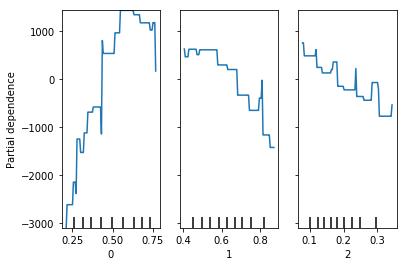

In [7]:
plot_partial_dependence(reg, X, features) 

# LIME

The recipe for training local surrogate models:

* Select your instance of interest for which you want to have an explanation of its black box prediction.
* Perturb your dataset and get the black box predictions for these new points. 
* Weight the new samples according to their proximity to the instance of interest.
* Train a weighted, interpretable model on the dataset with the variations.
* Explain the prediction by interpreting the local model.

In [8]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread

Notebook run using keras: 2.4.3


# Using a pretrained Inception model

In [9]:
inet_model = inc_net.InceptionV3()

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

let's get the top 5 predictions

('n02133161', 'American_black_bear', 0.6371598)
('n02105056', 'groenendael', 0.031818077)
('n02104365', 'schipperke', 0.029944299)
('n01883070', 'wombat', 0.028509492)
('n01877812', 'wallaby', 0.025093522)


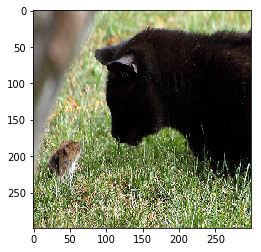

In [10]:
images = transform_img_fn(['cat_mouse.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

Let's get the explanation with LIME. Use the package from the authors: `pip install lime`.

Here is the API: https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.explanation

In [11]:
import os,sys
import lime
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [12]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 5min 52s, sys: 38.7 s, total: 6min 31s
Wall time: 3min 9s


Let's see the explanation for the top class ( Black Bear). We can see the top 5 superpixels that are most positive towards the class with the rest of the image present (hide_rest=False).

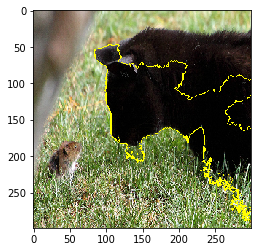

In [14]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

We can also see the 'pros and cons' (pros in green, cons in red)

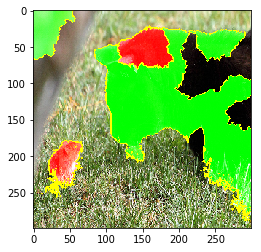

In [15]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

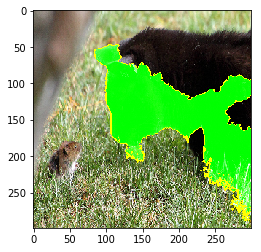

In [19]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

# SHAP

Let's use the cervical cancer data from the UCI repository: https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29.

In [33]:
cancer = pd.read_csv('risk_factors_cervical_cancer.csv', na_values='?')
cancer.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


In [34]:
list(cancer)

['Age',
 'Number of sexual partners',
 'First sexual intercourse',
 'Num of pregnancies',
 'Smokes',
 'Smokes (years)',
 'Smokes (packs/year)',
 'Hormonal Contraceptives',
 'Hormonal Contraceptives (years)',
 'IUD',
 'IUD (years)',
 'STDs',
 'STDs (number)',
 'STDs:condylomatosis',
 'STDs:cervical condylomatosis',
 'STDs:vaginal condylomatosis',
 'STDs:vulvo-perineal condylomatosis',
 'STDs:syphilis',
 'STDs:pelvic inflammatory disease',
 'STDs:genital herpes',
 'STDs:molluscum contagiosum',
 'STDs:AIDS',
 'STDs:HIV',
 'STDs:Hepatitis B',
 'STDs:HPV',
 'STDs: Number of diagnosis',
 'STDs: Time since first diagnosis',
 'STDs: Time since last diagnosis',
 'Dx:Cancer',
 'Dx:CIN',
 'Dx:HPV',
 'Dx',
 'Hinselmann',
 'Schiller',
 'Citology',
 'Biopsy']

In [35]:
cancer_data = cancer[['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies',
 'Smokes', 'Smokes (years)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)',
 'IUD', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs: Number of diagnosis', 'STDs: Time since first diagnosis',
 'STDs: Time since last diagnosis', 'Biopsy']]
cancer_data.isna().sum()

Age                                   0
Number of sexual partners            26
First sexual intercourse              7
Num of pregnancies                   56
Smokes                               13
Smokes (years)                       13
Hormonal Contraceptives             108
Hormonal Contraceptives (years)     108
IUD                                 117
IUD (years)                         117
STDs                                105
STDs (number)                       105
STDs: Number of diagnosis             0
STDs: Time since first diagnosis    787
STDs: Time since last diagnosis     787
Biopsy                                0
dtype: int64

In [40]:
cancer_data_imputed = cancer_data.fillna(cancer_data.mode().iloc[0])
cancer_data_imputed.isna().sum()

Age                                 0
Number of sexual partners           0
First sexual intercourse            0
Num of pregnancies                  0
Smokes                              0
Smokes (years)                      0
Hormonal Contraceptives             0
Hormonal Contraceptives (years)     0
IUD                                 0
IUD (years)                         0
STDs                                0
STDs (number)                       0
STDs: Number of diagnosis           0
STDs: Time since first diagnosis    0
STDs: Time since last diagnosis     0
Biopsy                              0
dtype: int64

In [76]:
from sklearn.ensemble import RandomForestClassifier
cancer_arr = cancer_data_imputed.to_numpy()
X = cancer_arr[:,:-1]
y = cancer_arr[:,-1].astype(np.int32)
print(X.shape)
print(y.shape)

(858, 15)
(858,)


In [77]:
X_train, y_train = X[:700], y[:700]
X_test, y_test = X[700:], y[700:]

In [78]:
X_test

array([[28.,  1., 17., ...,  0.,  1.,  1.],
       [29.,  2., 17., ...,  0.,  1.,  1.],
       [26.,  4., 13., ...,  0.,  1.,  1.],
       ...,
       [25.,  2., 17., ...,  0.,  1.,  1.],
       [33.,  2., 24., ...,  0.,  1.,  1.],
       [29.,  2., 20., ...,  0.,  1.,  1.]])

In [79]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9556962025316456

Let's look at the RF's mean decrease in impurity: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#tree-s-feature-importance-from-mean-decrease-in-impurity-mdi. This is calculated on the training data :(, and measures how well a split is abel to segregate classes of data for a feature.

Text(0.5, 0, 'Random Forest Feature Importance')

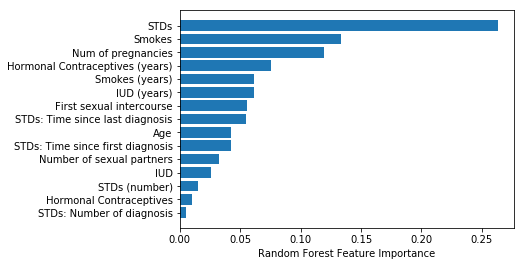

In [80]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh([x for _, x in sorted(zip(sorted_idx, list(cancer_data_imputed)), key=lambda pair: pair[0])],
         clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Now let's use the Shapley value. use the package shap: `pip install shap`. The documentation can be found here https://github.com/slundberg/shap.

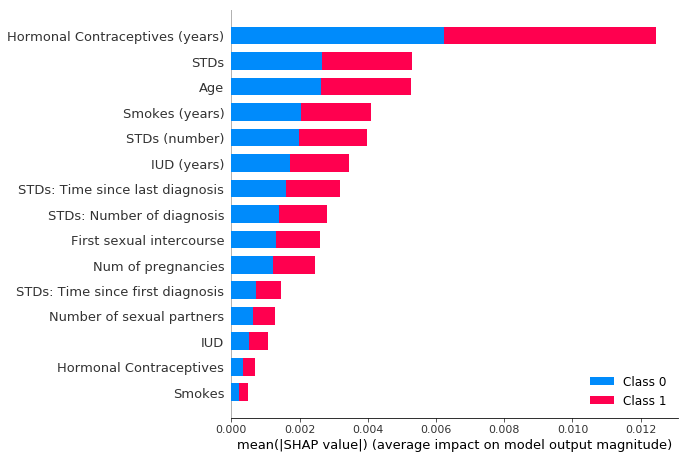

In [119]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf)
X_train_df = pd.DataFrame(X_train)
X_train_df.columns = list(cancer_data_imputed)[:-1]
shap_values = explainer.shap_values(X_train_df)
shap.summary_plot(shap_values, X_test, feature_names=list(cancer_data_imputed)[:-1])